This is a Pytorch lightning adaptation of the code presented in the Pytorch tutorial of UVA"s Deep Learning Course

https://uvadlc.github.io/

In [133]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pytorch_lightning as pl
import torchmetrics

from torch import nn, optim
import torch.utils.data as data
from datasets import Dataset


# Data

## Pytorch `Dataset` class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: `__getitem__`, and `__len__`. The get-item function has to return the $i$-th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows

In [134]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

Let"s try to create that dataset and inspect it

In [135]:
xor_dataset = XORDataset(size=200)
print("Size of dataset:", len(xor_dataset))
print("Data point 0:", xor_dataset[0])

Size of dataset: 200
Data point 0: (tensor([ 0.0088, -0.0899]), tensor(0))


To better relate to the dataset, we visualize the samples below.

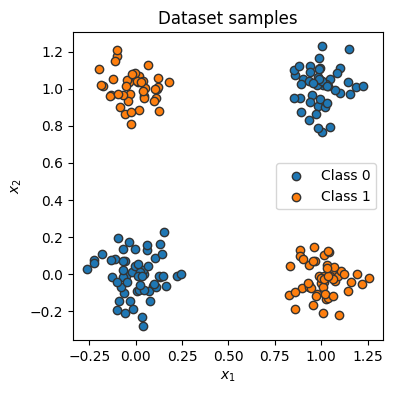

In [136]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
visualize_samples(xor_dataset.data, xor_dataset.label)
plt.show()

## HuggingFace `Dataset` class

While not strictly necessary, I personally like to work with HuggingFace datasets, especially because of its `DataBuilder` class and its `train_test_split` method

In [137]:
# Convert PyTorch dataset to Hugging Face dataset
hf_dataset = Dataset.from_dict({
    "input": [data[0] for data in xor_dataset],
    "label": [data[1] for data in xor_dataset],
})

In [138]:
print(next(iter(xor_dataset)))
print(next(iter(hf_dataset)))

(tensor([ 0.0088, -0.0899]), tensor(0))
{'input': [0.00878931488841772, -0.08988972753286362], 'label': 0}


As we can see, one problem with transforming our Pytorch dataset into a Huggingface dataset is that we usually convert tensors into lists. For this, we will need to re-transform them into tensors during the data loading process via the `_collate_batch()` function

> This is more "realistic" as we don"t usually have datasets in tensor form

## `DataModule`

In [139]:
class XORDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_dataset_size: int,
        test_dataset_size: int,
        val_split_size: int,
        batch_size: int,
        num_workers: int,
        random_seed: int=42,
    ):  
        if val_split_size >= train_dataset_size:
            raise ValueError("Validation size needs to be smaller than training size")
        
        super().__init__()
        self._train_dataset_size = train_dataset_size
        self._test_dataset_size = test_dataset_size
        self._val_split_size = val_split_size
        self._batch_size = batch_size
        self._num_workers = num_workers
        self._random_seed = random_seed
    
    def _generate_data(self, size):
        data =  XORDataset(size=size)
        # Note: We transform them into a list to make it more "realistic"
        return Dataset.from_dict({
            "input": [item[0] for item in data],
            "label": [item[1] for item in data],
        })
    
    def setup(self, stage):
        if stage == "fit":
            train_ds = self._generate_data(self._train_dataset_size)
            splits = train_ds.train_test_split(
                test_size=self._val_split_size, seed=self._random_seed
            )
            self._train_ds = splits["train"]
            self._val_ds = splits["test"]
            
        if stage == "test":
            self._test_ds = self._generate_data(self._test_dataset_size)

    def _collate_batch(self, examples):
        # We need to transform them from list to tensor
        inputs = torch.tensor([example["input"] for example in examples], dtype=torch.float32)
        labels = torch.tensor([example["label"] for example in examples], dtype=torch.float32).unsqueeze(1)
        return {"input": inputs, "label": labels}

    def train_dataloader(self):
        return data.DataLoader(
            dataset=self._train_ds,
            batch_size=self._batch_size,
            shuffle=True,
            collate_fn=self._collate_batch,
            num_workers=self._num_workers,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=self._val_ds,
            batch_size=self._batch_size,
            shuffle=False,
            collate_fn=self._collate_batch,
            num_workers=self._num_workers,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=self._test_ds,
            batch_size=self._batch_size,
            shuffle=False,
            collate_fn=self._collate_batch,
            num_workers=self._num_workers,
        )    

Let"s initialize the `DataModule` and show the first batch

In [140]:
# Initialize the XORDataModule
xor_data_module = XORDataModule(
    train_dataset_size=1000,
    test_dataset_size=200,
    val_split_size=200,
    batch_size=32,
    num_workers=0,
    random_seed=42
)

# Setup the data module (usually done automatically in training)
xor_data_module.setup(stage="fit")

# Get the train dataloader
train_loader = xor_data_module.train_dataloader()

# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
batch = next(iter(train_loader))

# # The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the 
# # dimensions of the data point returned from the dataset class
print("Data inputs", batch["input"].shape)
print("Data labels", batch["label"].shape)

Data inputs torch.Size([32, 2])
Data labels torch.Size([32, 1])


# Model

In Pytorch Lightning, we usually define the model structure, the loss function and the optimization hyperparameters at the same time

In [141]:
class XORClassifier(pl.LightningModule):

    def __init__(self, num_inputs, num_hidden, num_outputs, learning_rate: float=0.1):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        
        self.loss_fn =  nn.BCEWithLogitsLoss()
        self.learning_rate = learning_rate
        
        self.accuracy = torchmetrics.Accuracy(
            task="multiclass", num_classes=2
        )
        self.f1_score = torchmetrics.F1Score(
            task="multiclass", num_classes=2
        )

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x
    
    def _common_step(self, batch, batch_idx):
        x = batch["input"]
        y = batch["label"]
        
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        
        # Apply sigmoid to convert logits to probabilities
        probs = torch.sigmoid(logits)  # Shape: [batch_size, 1]
        # Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
        preds = (probs > 0.5).int()
        
        return loss, preds, y
    
    def training_step(self, batch, batch_idx):
        loss, preds, y = self._common_step(batch, batch_idx)

        accuracy = self.accuracy(preds, y)
        f1_score = self.f1_score(preds, y)
        self.log_dict(
            {
                "train_loss": loss,
                "train_accuracy": accuracy,
                "train_f1_score": f1_score,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return {"loss": loss, "logits": logits, "y": y}
        
    
    def validation_step(self, batch, batch_idx):
        loss, preds, y = self._common_step(batch, batch_idx)
        
        # Compute accuracy and F1 score for validation
        accuracy = self.accuracy(preds, y)
        f1_score = self.f1_score(preds, y)

        # Log validation loss, accuracy, and F1 score
        self.log("val_loss", loss)
        self.log("val_accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_f1_score", f1_score, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, preds, y = self._common_step(batch, batch_idx)
        
        # Compute accuracy and F1 score for test
        accuracy = self.accuracy(preds, y)
        f1_score = self.f1_score(preds, y)

        # Log test loss, accuracy, and F1 score
        self.log("test_loss", loss)
        self.log("test_accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_f1_score", f1_score, on_step=False, on_epoch=True, prog_bar=True)
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)
    
    ##########
    
    # TODO
    # def predict_step(self, batch, batch_idx):
    #     pass

In [142]:
model = XORClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
print(model)

XORClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
  (loss_fn): BCEWithLogitsLoss()
  (accuracy): MulticlassAccuracy()
  (f1_score): MulticlassF1Score()
)


Printing the model lists all submodules it contains. The parameters of a module can be obtained by using its `parameters()` functions, or `named_parameters()` to get a name to each parameter object. For our small neural network, we have the following parameters:

In [143]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


Each linear layer has a weight matrix of the shape `[output, input]`, and a bias of the shape `[output]`. The tanh activation function does not have any parameters. Note that parameters are only registered for `nn.Module` objects that are direct object attributes, i.e. `self.a = ...`. If you define a list of modules, the parameters of those are not registered for the outer module and can cause some issues when you try to optimize your module. There are alternatives, like `nn.ModuleList`, `nn.ModuleDict` and `nn.Sequential`, that allow you to have different data structures of modules. We will use them in a few later tutorials and explain them there. 

# Trainer

In [144]:
trainer = pl.Trainer(
    devices=1,
    accelerator="gpu",
    min_epochs=1,
    max_epochs=3,
    precision="16-mixed",
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [145]:
trainer.fit(model, xor_data_module)


  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | linear1  | Linear             | 12     | train
1 | act_fn   | Tanh               | 0      | train
2 | linear2  | Linear             | 5      | train
3 | loss_fn  | BCEWithLogitsLoss  | 0      | train
4 | accuracy | MulticlassAccuracy | 0      | train
5 | f1_score | MulticlassF1Score  | 0      | train
--------------------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [146]:
trainer.validate(model, xor_data_module)

Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_accuracy                  1.0
      val_f1_score                  1.0
        val_loss            0.02487824112176895
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.02487824112176895, 'val_accuracy': 1.0, 'val_f1_score': 1.0}]